### Import libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import WordCloud, STOPWORDS
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix

import string
import re

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

from keras.utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense , LSTM , Embedding
from keras.models import Sequential
from keras.callbacks import EarlyStopping

import warnings
warnings.filterwarnings('ignore')

import pickle

In [3]:
data = pd.read_csv("/kaggle/input/amazon-fine-food-reviews/Reviews.csv")
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [4]:
data.shape

(568454, 10)

In [5]:
# Check null values
data.isna().sum().to_frame(name='# of missing values')

,# of missing values
Id,0
ProductId,0
UserId,0
ProfileName,16
HelpfulnessNumerator,0
HelpfulnessDenominator,0
Score,0
Time,0
Summary,27
Text,0


### Remove rows which are having null values

In [6]:
total_rows =  data.shape[0]
data.dropna(how='any',inplace=True)
remaining_rows= data.shape[0]

removed_rows = total_rows-remaining_rows
print("No. of rows removed :", removed_rows)

print(f"\nPercentage of data removed:{np.round((removed_rows/total_rows)*100,2)}%")
print(f"Percentage of data remaining:{np.round((remaining_rows/total_rows)*100,2)}%")

No. of rows removed : 43

Percentage of data removed:0.01%
Percentage of data remaining:99.99%


### Remove duplicate rows

In [7]:
a =  data.shape[0]
data.drop_duplicates(inplace=True, subset=['Score','Text'])
b = data.shape[0]

print("No. of rows removed :", a-b)

print(f"\nPercentage of data removed: {np.round(((a-b)/total_rows)*100,2)}%")
print(f"Percentage of data remaining: {np.round((b/total_rows)*100,2)}%")

No. of rows removed : 174750

Percentage of data removed: 30.74%
Percentage of data remaining: 69.25%


### Remove outliers

In [8]:
a =  data.shape[0]

idx = data[data["HelpfulnessNumerator"]>data["HelpfulnessDenominator"]].index
data.drop(index=idx, inplace=True)

b = data.shape[0]

print("No. of rows removed :", a-b)

print(f"\nPercentage of data removed:{np.round(((a-b)/total_rows)*100,2)}%")
print(f"Percentage of data remaining:{np.round((b/total_rows)*100,2)}%")

No. of rows removed : 2

Percentage of data removed:0.0%
Percentage of data remaining:69.25%


### Create target column using Score

In [9]:
## `Score` > 3 : "Positive" 
## `Score` == 3 : "Neutral"
## `Score` < 3 : "Negative"

def create_target(x):
    
    return "Positive" if x>3 else "Negative" if x<3 else "Neutral"

data.loc[:, 'target'] = data.Score.apply(create_target)

In [10]:
# target column 
data[['Score', 'target']].sample(5)

,Score,target
236109,2,Negative
80515,5,Positive
104172,5,Positive
311258,5,Positive
448567,5,Positive


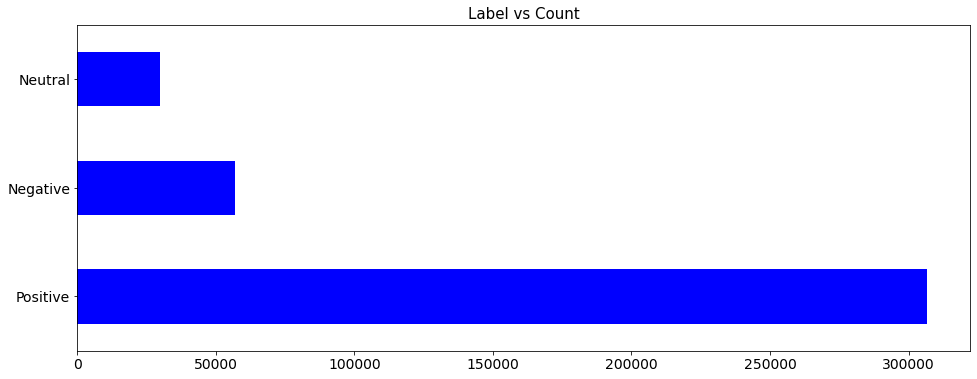

In [11]:
fig, ax = plt.subplots(figsize=(16, 6))

vc = data.target.value_counts()
vc.plot.barh(color="blue",fontsize=14,ax=ax)
ax.set_title("Label vs Count", fontsize=15)
plt.show()

### Down sampling (remove some positive and negative reviews)

In [12]:
neutral = data.loc[data.target=="Neutral"] # 29770 reviews

positive = data.loc[data.target=="Positive"].sample(50000)

negative = data.loc[data.target=="Negative"].sample(50000)

data = pd.concat([positive, negative, neutral])
data.shape

(129770, 11)

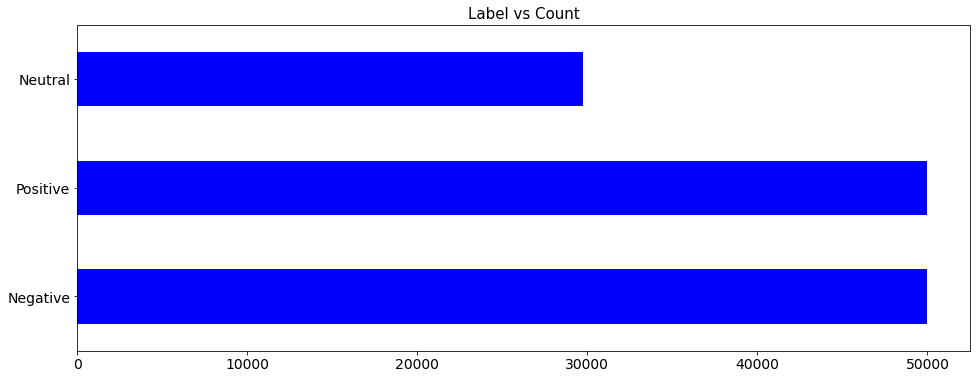

In [13]:
fig, ax = plt.subplots(figsize=(16, 6))

vc = data.target.value_counts()
vc.plot.barh(color="blue",fontsize=14,ax=ax)
ax.set_title("Label vs Count", fontsize=15)
plt.show()

### Target distribution (after)

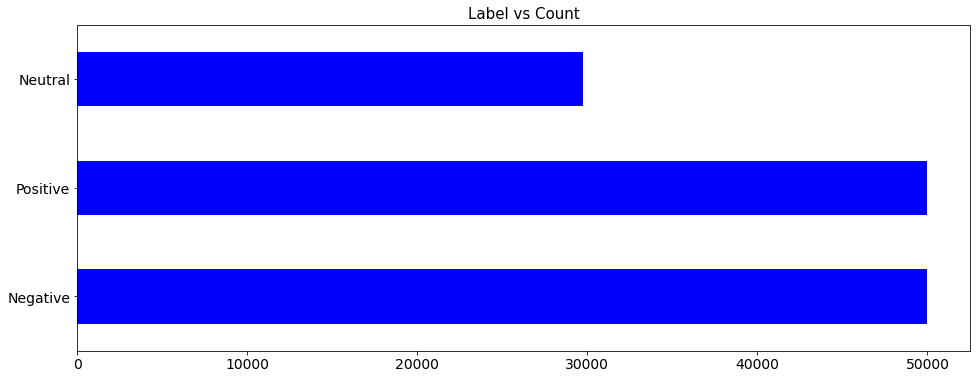

In [14]:
fig, ax = plt.subplots(figsize=(16, 6))

vc = data.target.value_counts()
vc.plot.barh(color="blue",fontsize=14,ax=ax)
ax.set_title("Label vs Count", fontsize=15)
plt.show()

### Stop words

In [15]:
# stopwords
total_stopwords = set(stopwords.words('english'))

# subtract negative stop words like no, not, don't etc.. from total_stopwords
negative_stop_words = set(word for word in total_stopwords 
                          if "n't" in word or 'no' in word)

final_stopwords = total_stopwords - negative_stop_words

# 
final_stopwords.add("one")
print(final_stopwords)

{'just', 'by', 'have', 'through', 'on', "you've", 'ain', 'ma', 'both', 'we', 'where', 'won', 'in', 'so', 'having', 'under', 'too', 'will', 'who', 'didn', 'was', 'here', 'herself', 'same', 'mustn', 'hadn', 'a', 'this', 'aren', "she's", 'of', 'all', 'what', 'don', 't', 'needn', 'into', 'because', "that'll", 'wasn', 'once', 'hasn', 'it', 'until', 'whom', 'those', 'off', 'were', 'haven', 'do', 'they', 'being', 'is', 'doesn', 'at', 'yourselves', 'with', 'some', 'while', 'me', "you'll", 'other', "you're", 'when', 'shouldn', 'which', 'more', 'should', 'ourselves', 'then', 'above', 's', 'below', 'mightn', 'few', 've', 'about', 'an', 'o', 'i', 'himself', 'yourself', "you'd", 'the', 'how', 'them', 'that', 'again', 'he', 'did', 'can', 'wouldn', 'their', 'themselves', 'she', 'any', 'are', 'll', 'there', 'ours', 'his', 'only', 'shan', 'why', 'during', 'itself', 'between', 'd', 'if', 'my', 'isn', 'out', 'him', 'than', 'am', 'you', 'down', 'before', 'further', 'and', "it's", 'for', 'or', 'its', 'such

### Remove unwanted words from reviews
#### Ex. html tags, punctuation, stop words, etc..

In [16]:
#stemming object
stemmer = PorterStemmer()

# ---------------------------------------------
HTMLTAGS = re.compile('<.*?>')
table = str.maketrans(dict.fromkeys(string.punctuation))
remove_digits = str.maketrans('', '', string.digits)
MULTIPLE_WHITESPACE = re.compile(r"\s+")
# ---------------------------------------------

In [17]:
def preprocessor(review):
    # remove html tags
    review = HTMLTAGS.sub(r'', review)

    # remove puncutuation
    review = review.translate(table)
    
    # remove digits
    review = review.translate(remove_digits)
    
    # lower case all letters
    review = review.lower()
    
    # replace multiple white spaces with single space
    review = MULTIPLE_WHITESPACE.sub(" ", review).strip()
    
    # remove stop words
    review = [word for word in review.split()
              if word not in final_stopwords]
    
    # stemming
    review = ' '.join([stemmer.stem(word) for word in review])
    
    return review

In [18]:
print("Before preprocessing : ")
data.Text.iloc[6]

Before preprocessing : 


"This is my very favorite white wine.  I don't like dry wines.  This wine is fruity and semi-sweet.  I serve it guests and family and no one has ever had anything negative to say. :)"

In [19]:
# apply preprocessing function

data.Text = data.Text.apply(preprocessor) 
print("After preprocessing : ")
data.Text.iloc[6]

After preprocessing : 


'favorit white wine dont like dri wine wine fruiti semisweet serv guest famili no ever anyth neg say'

In [20]:
def generate_wcloud(text):
    stopwords = set(STOPWORDS)
    
    wordcloud = WordCloud(stopwords=stopwords, background_color='white')
    wordcloud.generate(text)
    
    plt.figure(figsize=(15,7))
    plt.axis('off')
    plt.imshow(wordcloud, interpolation='bilinear')
    return plt.show()

### Word cloud for Positive reviews

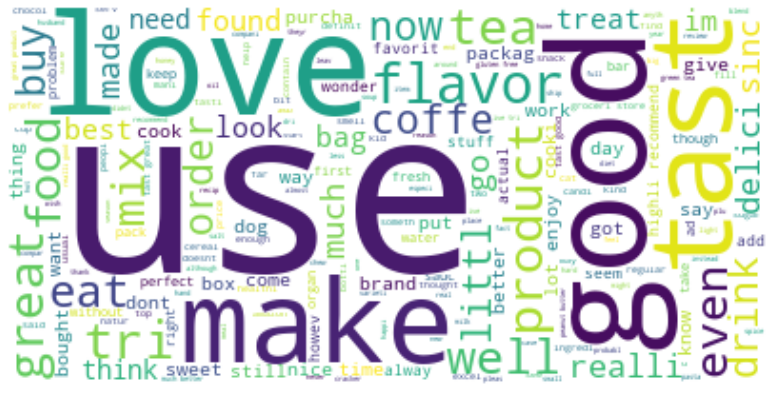

In [21]:
pos = data.loc[data.target=="Positive"].Text
text = " ".join(review for review in pos.astype(str))

generate_wcloud(text)

### Word cloud for Negative reviews

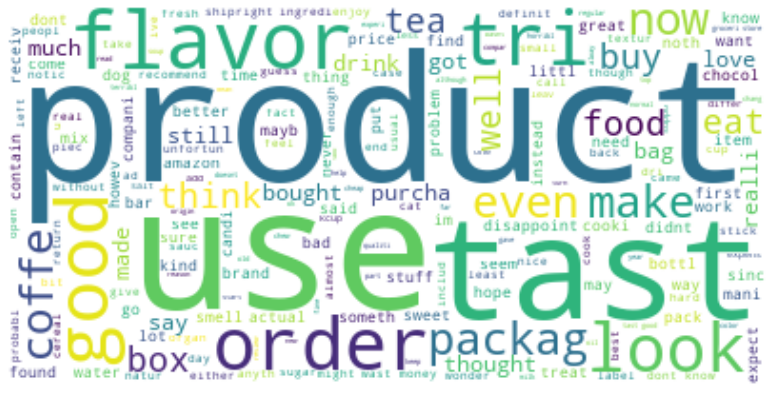

In [22]:
pos = data.loc[data.target=="Negative"].Text
text = " ".join(review for review in pos.astype(str))

generate_wcloud(text)

### Word cloud for Neutral reviews

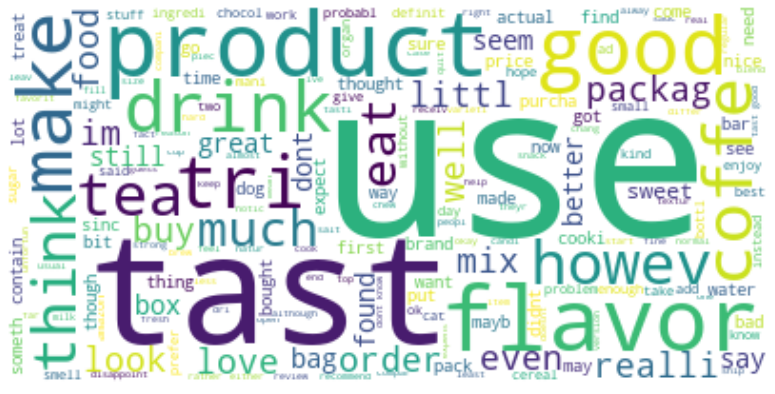

In [23]:
pos = data.loc[data.target=="Neutral"].Text
text = " ".join(review for review in pos.astype(str))

generate_wcloud(text)

<h2 style = "font-size:25px; font-family:Garamond ; font-weight : bold; background-color: #007580; color :#fed049   ; text-align: center; border-radius: 5px 5px; padding: 5px">Train Test Split</h2>

#### Train set : 70% of data
#### Test set : 30% of data

In [24]:
X = data.Text
y = data.target

X_train, X_test, y_train, y_test = train_test_split(
    
    X, y, test_size=0.20, random_state=1, stratify=y)

In [25]:
X_train.shape, X_test.shape

((103816,), (25954,))

<h2 style = "font-size:25px; font-family:Garamond ; font-weight : bold; background-color: #007580; color :#fed049   ; text-align: center; border-radius: 5px 5px; padding: 5px">Vectorization</h2>

### Bag of Words Vectorizer

In [26]:
bow_vectorizer = CountVectorizer(max_features=10000)
bow_vectorizer.fit(X_train)

# transform
bow_X_train = bow_vectorizer.transform(X_train)
bow_X_test = bow_vectorizer.transform(X_test)

### TF-IDF Vectorizer

In [27]:
tfidf_vectorizer = TfidfVectorizer(max_features=10000)
tfidf_vectorizer.fit(X_train)

# transform
tfidf_X_train = tfidf_vectorizer.transform(X_train)
tfidf_X_test = tfidf_vectorizer.transform(X_test)

###  Label Encoding

In [28]:
labelEncoder = LabelEncoder()

y_train = labelEncoder.fit_transform(y_train)
y_test = labelEncoder.transform(y_test)

labels = labelEncoder.classes_.tolist()
print(labels) # index-> class

['Negative', 'Neutral', 'Positive']


<a id="4"></a>
<h2 style = "font-size:30px; font-family:Garamond ; font-weight : bold; background-color: #007580; color :#fed049   ; text-align: center; border-radius: 5px 5px; padding: 10px">4. Model Training</h2>

In [29]:
### 
def train_and_eval(model, trainX, trainY, testX, testY):

    # training
    _ = model.fit(trainX, trainY)

    # predictions
    y_preds_train = model.predict(trainX)
    y_preds_test = model.predict(testX)

    # evaluation
    print()
    print(model)
    print(f"Train accuracy score : {accuracy_score(y_train, y_preds_train)}")
    print(f"Test accuracy score : {accuracy_score(y_test, y_preds_test)}")
    print('\n',40*'-')

## Logistic Regression with BoW

In [ ]:
# Hyperparameters
C = [0.001, 0.01, 0.1, 1, 10]

for c in C: 
    # Define model
    log_model = LogisticRegression(C=c, max_iter=500, random_state=1)
    u
    # Train and evaluate model
    train_and_eval(model=log_model,
                   trainX=bow_X_train,
                   trainY=y_train,
                   testX=bow_X_test,
                   testY=y_test)

## Naive Bayes Classifier with BoW

In [ ]:
alphas = [0, 0.2, 0.6, 0.8, 1]

for a  in alphas: 
    # Define model
    nb_model = MultinomialNB(alpha=a)

    # Train and evaluate model
    train_and_eval(model=nb_model,
                   trainX=bow_X_train,
                   trainY=y_train,
                   testX=bow_X_test,
                   testY=y_test)

## Logistic Regression with Tf-Idf

In [ ]:
# Hyperparameters
C = [0.001, 0.01, 0.1, 1, 10]

for c in C: 
    # Define model
    log_model = LogisticRegression(C=c, max_iter=500, random_state=1)
    
    # Train and evaluate model
    train_and_eval(model=log_model,
                   trainX=tfidf_X_train,
                   trainY=y_train,
                   testX=tfidf_X_test,
                   testY=y_test)

## Naive Bayes classifier with Tf-Idf

In [ ]:
alphas = [0, 0.2, 0.6, 0.8, 1]

for a  in alphas: 
    # Define model
    nb_model = MultinomialNB(alpha=a)

    # Train and evaluate model
    train_and_eval(model=nb_model,
                   trainX=tfidf_X_train,
                   trainY=y_train,
                   testX=tfidf_X_test,
                   testY=y_test)

<a id="5"></a>
<h2 style = "font-size:30px; font-family:Garamond ; font-weight : bold; background-color: #007580; color :#fed049   ; text-align: center; border-radius: 5px 5px; padding: 10px">5. Model Evaluation</h2>

In [ ]:
def plot_cm(y_true, y_pred):
    plt.figure(figsize=(6,6))
    
    cm = confusion_matrix(y_true, y_pred, normalize='true')
    
    sns.heatmap(
        cm, annot=True, cmap='Blues', cbar=False, fmt='.2f',
        xticklabels=labels, yticklabels=labels)
    
    return plt.show()

### Best model : Logistic Regression(C=1) with TfIdf data

In [ ]:
bmodel = LogisticRegression(C=1, max_iter=500, random_state=1)
bmodel.fit(tfidf_X_train, y_train)

In [ ]:
# predictions
y_preds_train = bmodel.predict(tfidf_X_train)
y_preds_test = bmodel.predict(tfidf_X_test)

### Accuracy

In [ ]:
print(f"Train accuracy score : {accuracy_score(y_train, y_preds_train)}")
print(f"Test accuracy score : {accuracy_score(y_test, y_preds_test)}")

### Confusion Matrix

In [ ]:
plot_cm(y_test, y_preds_test)

### Observations

#### - Our model is performing better on classifying positive and negative reviews.
#### - Need improvement in classifying the neutral reviews (Any suggestions??)

<a id="6"></a>
<h2 style = "font-size:30px; font-family:Garamond ; font-weight : bold; background-color: #007580; color :#fed049   ; text-align: center; border-radius: 5px 5px; padding: 10px">6. Deployment</h2>

### Save model and transformer

In [ ]:
with open("transformer.pkl", "wb") as f:
    pickle.dump(tfidf_vectorizer, f)
    
with open("model.pkl", "wb") as f:
    pickle.dump(bmodel, f)

### Prediction on single review

In [ ]:
# labels = ['Negative', 'Neutral', 'Positive']
def get_sentiment(review):
    # preprocessing
    x = preprocessor(review)1q1
    #vectorization
    x = tfidf_vectorizer.transform([x])
    #prediction
    y = int(bmodel.predict(x.reshape(1,-1)))
    return labels[y]

In [ ]:
# positve review
review = "This chips packet is very tasty. I highly recommend this!"
print(f"This is a {get_sentiment(review)} review!")

In [ ]:
# positve review
review = "This product is a waste of money. Don't buy this!!"
print(f"This is a {get_sentiment(review)} review!")

## Next steps..

### Web app and Deployment code will be updated soon on my github

#### Link: https://github.com/ashok49473/reviews-sentiment-classifier

## References
---

#### Theory : https://www.pyoneer.io/post/5-reasons-why-sentiment-analysis-is-important

#### CSS styling: https://www.kaggle.com/bhuvanchennoju/ancient-roots-of-agriculture-a-data-overview

#### word cloud : https://re-thought.com/creating-wordclouds-in-python/

#### Keras :  https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/

